## Код написан в рамках конкурса: https://www.kaggle.com/c/lish-moa
Размещается по адресу : https://www.kaggle.com/milev3005/notebook3c105af58e

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import matplotlib.pyplot as plt
# %matplotlib nbagg
%matplotlib inline
import seaborn as sns

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
test_features['cp_type'] = test_features['cp_type'].map({'trt_cp':0, 'ctl_vehicle':1})
test_features['cp_dose'] = test_features['cp_dose'].map({'D1':0, 'D2':1})

train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_features['cp_type'] = train_features['cp_type'].map({'trt_cp':0, 'ctl_vehicle':1})
train_features['cp_dose'] = train_features['cp_dose'].map({'D1':0, 'D2':1})

train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

Первое,небольшой анализ структуры данных.

In [3]:
# Убедимся, что нет перескечений
set(test_features['sig_id']) & set(train_features['sig_id'])

set()

In [4]:
train_features[['cp_type']].value_counts()

cp_type
0          21948
1           1866
dtype: int64

In [5]:
train_features[['cp_dose']].value_counts()

cp_dose
0          12147
1          11667
dtype: int64

In [6]:
def create_mean_std_df(df):
    means = df.mean()
    stds = df.std()
    ret_df = pd.concat([means, stds], axis=1).reset_index()
    ret_df.columns = ['index', 'mean', 'std']
    ret_df['pref'] = ret_df['index'].apply(lambda x: x.split('-')[0])
    ret_df['post'] = ret_df['index'].apply(lambda x: x.split('-')[1])
    return ret_df

def scatter(y, x=None, color= None):
    fig, ax = plt.subplots()
    un_c = color.unique()
    for i, col in enumerate(un_c):
        y_i = y[color == col]
        if type(x) != pd.core.series.Series:
            x_i = range(0 + i * (y.shape[0] - y_i.shape[0]),
                    (1 - i)*y_i.shape[0] + i * y.shape[0])
        else:
            x_i = x[color == col]
        ax.scatter(x_i, y_i, c=col, label=col,
               alpha=0.3)
        ax.set_ylabel(y.name)
        ax.legend()
        ax.grid(True)
    plt.show()

In [7]:
tr = create_mean_std_df(train_features.iloc[:,4:])

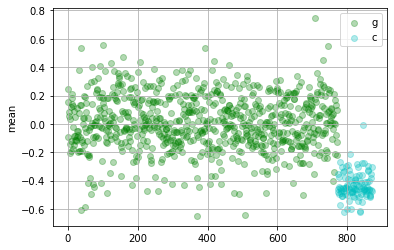

In [8]:
scatter(y=tr['mean'], color = tr['pref'])

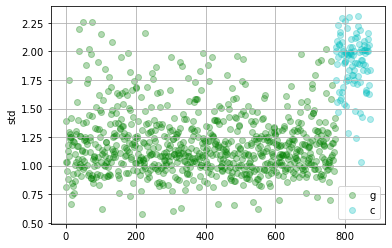

In [9]:
scatter(y = tr['std'], color = tr['pref'])

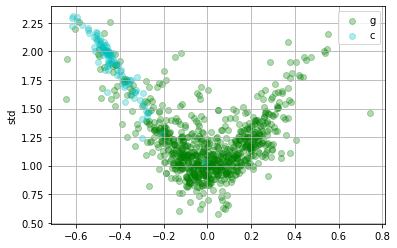

In [10]:
scatter(y = tr['std'], x = tr['mean'], color = tr['pref'])

In [11]:
corrMatrix = train_features.corr()

In [12]:
corrMatrix.tail(10)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
c-90,0.092025,-0.056778,0.021635,-0.648726,-0.034557,-0.183325,-0.091892,-0.387193,0.210235,-0.084153,...,1.000000,0.862366,0.868444,0.877901,0.895854,0.818838,0.888795,0.860923,0.816530,0.794279
c-91,0.084773,-0.053159,0.025650,-0.629025,-0.000934,-0.186048,-0.045385,-0.361679,0.171185,-0.073982,...,0.862366,1.000000,0.823310,0.859351,0.865275,0.803295,0.876358,0.849142,0.818789,0.784466
c-92,0.076649,-0.079995,0.041799,-0.633479,-0.022478,-0.166786,-0.089801,-0.351508,0.207207,-0.078695,...,0.868444,0.823310,1.000000,0.846090,0.883464,0.793390,0.867251,0.836722,0.802289,0.767997
c-93,0.107095,-0.032101,0.029549,-0.668520,-0.034891,-0.190383,-0.089818,-0.397062,0.192473,-0.083806,...,0.877901,0.859351,0.846090,1.000000,0.882516,0.787176,0.873935,0.840606,0.811567,0.799651
c-94,0.104947,-0.064898,0.028690,-0.656116,-0.042638,-0.178312,-0.081073,-0.388885,0.211185,-0.065120,...,0.895854,0.865275,0.883464,0.882516,1.000000,0.819529,0.894631,0.862876,0.824202,0.827228
c-95,0.098305,-0.112583,0.025122,-0.600758,-0.011237,-0.158105,-0.016778,-0.378084,0.202341,-0.082060,...,0.818838,0.803295,0.793390,0.787176,0.819529,1.000000,0.821950,0.811155,0.787529,0.758110
c-96,0.087668,-0.067116,0.026105,-0.646784,-0.022127,-0.182540,-0.083846,-0.379085,0.194619,-0.079270,...,0.888795,0.876358,0.867251,0.873935,0.894631,0.821950,1.000000,0.863061,0.819600,0.789649
c-97,0.092418,-0.067969,0.024246,-0.622840,-0.008487,-0.178812,-0.049951,-0.394904,0.193907,-0.095448,...,0.860923,0.849142,0.836722,0.840606,0.862876,0.811155,0.863061,1.000000,0.801809,0.775300
c-98,0.120323,-0.088916,0.031905,-0.640484,-0.002824,-0.170152,-0.079855,-0.366693,0.179097,-0.084408,...,0.816530,0.818789,0.802289,0.811567,0.824202,0.787529,0.819600,0.801809,1.000000,0.755991
c-99,0.117060,-0.075736,0.026250,-0.609238,-0.002308,-0.172124,-0.037579,-0.390581,0.192385,-0.079813,...,0.794279,0.784466,0.767997,0.799651,0.827228,0.758110,0.789649,0.775300,0.755991,1.000000


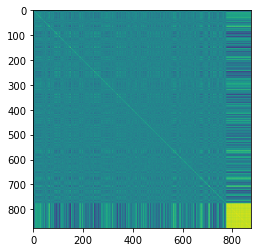

In [13]:
plt.imshow(corrMatrix)
plt.show()

Чем ярче цвет, тем ближе к 1, темный цвет - к -1.

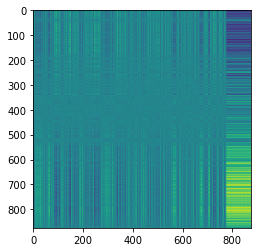

In [14]:
plt.imshow(corrMatrix.sort_values(by=list(corrMatrix.columns)))
plt.show()

Первая модель, которая была построена - logreg.

In [15]:
def mul_lab_logreg(test, train_X, train_y):
#   Шаблон для Submission
    sub = pd.DataFrame(test['sig_id'])
    
#   Пройдемся по каждой колонке и обучим одну модель логрег, выдадим pred_proba для колонки шаблона  
    col = train_y.columns.drop('sig_id')
    train_X.set_index('sig_id', inplace=True)
    df = pd.concat([train_X.iloc[:,0],
                    train_y.set_index('sig_id')], axis = 1)
    for c in tqdm(col):
        print(c)
        y = df.loc[:, c]
        clf = LogisticRegression(random_state=0, 
                         class_weight='balanced', 
                         n_jobs=6).fit(train_X, y)

        clf.fit(train_X, y)
        sub[c] = clf.predict_proba(test.drop('sig_id', axis=1)).T[1]
    return sub

# probs = mul_lab_logreg(test_features,train_features,train_targets_scored)

Далее опробован случайный лес.

In [16]:
def rfc(test, tr_X, train_y, n_estimators=30, criterion='gini', max_depth=15, min_samples_split=2,
                                     min_samples_leaf=1, max_samples=400, max_features = None):
#   Шаблон для Submission
    sub = pd.DataFrame(test['sig_id'])
    
#   Пройдемся по каждой колонке и обучим одну модель логрег, выдадим pred_proba для колонки шаблона  
    col = train_y.columns.drop('sig_id')
    train_X = tr_X.set_index('sig_id', inplace=False)
    df = pd.concat([train_X.iloc[:,0],
                    train_y.set_index('sig_id')], axis = 1)
    for c in tqdm(col):
        print(c)
#         for cv
        y = df.loc[:, c]
#         if y.sum() <= 2:
#             sub[c] = [0 for i in range(y.shape[0])]
#             continue
#       model
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, 
                                     max_depth=max_depth, min_samples_split=min_samples_split, 
                                     min_samples_leaf=min_samples_leaf, max_samples=max_samples,
                                     max_features=max_features,
                                     n_jobs=6, random_state=1998, ccp_alpha=0.0)
        clf.fit(train_X, y)
        print(clf.predict_proba(test.drop('sig_id', axis=1)))
        sub[c] = clf.predict_proba(test.drop('sig_id', axis=1)).T[1]
    return sub

def score(preds, true_y):
    log_preds = np.log(preds + 0.00000001)
    log_inv_preds = np.log(1 - preds)
    total = true_y * log_preds + (1 - true_y) * log_inv_preds
    return total.sum().sum() / (preds.shape[0]*preds.shape[1])

# probs = rfc(test_features,train_features,train_targets_scored, n_estimators=30, criterion='gini', max_depth=15, min_samples_split=2,
#                                      min_samples_leaf=5, max_samples=1000, max_features = 400)

In [17]:
# train_X, test_X, train_y, test_y = train_test_split( X, y, test_size=1/7.0, random_state=122)
# n_splits = 2
# k_fold = KFold(n_splits=n_splits)
# cv_list = []
# i = 0
# for train_indices, test_indices in k_fold.split(train_X):
#     X_tr = train_features.loc[train_indices, :]
#     y_tr = train_targets_scored.loc[train_indices, :]
#     X_test = train_features.loc[test_indices, :]
#     y_test = train_targets_scored.loc[test_indices, :].set_index('sig_id')
    
#     proba = rfc(X_test, X_tr, y_tr, n_estimators=30, criterion='gini',
#                 max_depth=15, min_samples_split=5, min_samples_leaf=5, 
#                 max_samples=1000, max_features = 0.5)
#     cv_list.append([proba.set_index('sig_id'), i])
#     i+=1

Реализован KNN. (0.04151)

In [18]:
class KNN():
    def __init__(self, n_samples=None, n_features=None):
        super().__init__()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.n_samples = n_samples
        self.n_features = n_features
        self.preds = None
        
    def fit(self, X_train, X_test, y_train, k, n_batches = 500):
        self.X_train = X_train.set_index('sig_id').to_numpy()
        preds_ind = X_test.index
        self.X_test = X_test.set_index('sig_id').to_numpy()
        preds_col = y_train.columns.drop('sig_id')
        self.y_train = y_train.set_index('sig_id').to_numpy()
#       Разбиваем выборку для того, чтобы избежать переполнения памяти
        batches = np.array_split(self.X_test, n_batches)
#       Тут будем сохранять для кааждого объекта из теста вероятность для каждого класса
        preds_arr = np.zeros((1, preds_col.shape[0]))
#       Проходим по батчам и находим сначала индексы ближайших, а потом средние. Если n_samples != total,
#       то будем брать для подсчета только часть выборки
        for batch in tqdm(batches):
            if self.n_samples:
                b_ind = np.random.choice(X_train.shape[0], self.n_samples)
                X_tr = self.X_train[b_ind]
                y_tr = self.y_train[b_ind]
            else:
                X_tr = self.X_train
                y_tr = self.y_train
#           Найдем индексы ближайших
            d = self.dist(X_tr, batch, k = k)
#           Для каждого наблюдения из батча составим предсказание по каждому классу
            for ind in d:
#                 preds = y_tr[ind].mean(axis=0).reshape(1, preds_col.shape[0])
                preds = np.average(y_tr[ind], axis=0, weights=[1/i for i in range(1, 1 + y_tr[ind].shape[0])]).reshape(1, preds_col.shape[0])
                preds_arr = np.concatenate((preds_arr, preds))
            
        self.preds = pd.DataFrame(data = preds_arr[1:], index=preds_ind, columns=preds_col)
        

    def dist(self, A, B, k=100):
        '''
        Считаем попарные расстояния между элементами матрицы А и В
        Возвращает для каждого элемента из В индексы k элементов из A наиболее близких к B
        Лист размера 'количество наблюдений в В * k'
        '''
        a = A.reshape(A.shape[0], 1, A.shape[1])
        b = B.reshape(1, B.shape[0], B.shape[1])
        d = ((a - b) ** 2).sum(axis = 2) ** 0.5
        list_ind = []
        for arr in d.T:
            ind = np.argpartition(arr, k)[:k]
            list_ind.append(ind)
        return list_ind
    
    def loss(self, preds, target):
        log_preds = preds.apply(lambda x: np.log(x + 0.000001))
        log_inv_preds =   preds.apply(lambda x: np.log(1 - x - 0.000001))
        total = target * log_preds + (1 - target) * log_inv_preds
        loss = - total.sum().sum() / (target.shape[0]*target.shape[1])
        return loss


In [19]:
train_X, test_X, train_y, test_y = train_test_split( train_features, train_targets_scored, test_size=1/7.0, random_state=122)

In [20]:
# loss_list = np.array([[0,0]])
# for i in range(100, 1000, 100):
#     knn = KNN(n_samples= 5000)
#     knn.fit(train_X, test_X, train_y, i)
#     loss_list = np.append(loss_list_3, [[knn.loss(knn.preds, test_y.drop('sig_id', axis = 1)), i]], axis=0)
#     print(knn.loss(knn.preds, test_y.drop('sig_id', axis = 1)))

In [21]:
# plt.scatter(loss_list[1:].T[1], loss_list[1:].T[0])
# plt.show()

In [22]:
# probs = rfc(test_features,train_features,train_targets_scored)

In [23]:
def cv(n_splits, data_X, data_y):
    kfold = KFold(n_splits=n_splits)
#     batches = np.array_split(X_test, n_batches)
    loss = []
    k_0 = 50
    n_b_0 = 500
    for train_index, test_index in kfold.split(data_X):
        X_train, X_test = data_X.loc[train_index], data_X.loc[test_index]
        y_train, y_test = data_y.loc[train_index], data_y.loc[test_index]
        knn = KNN()
        knn.fit(train_features, test_features, train_targets_scored, k_0, n_batches=n_b_0)
        loss.append([knn.loss(knn.preds, y_test.drop('sig_id', axis=1)), k_0,  n_b_0]) #Возможно нужно убрать sig_id
        k_0 += 10
#         n_b_0 += 50
    return loss

In [24]:
# loss_list = cv(3, train_features, train_targets_scored)

К сожалению, все попытки оказались тщетны и простое среднее дало результат выше. (0.02398)

In [25]:
# means = train_targets_scored.mean()
# zero_data = np.zeros(shape=(test_features.shape[0],means.shape[0]))
# preds = pd.DataFrame(zero_data, columns=means.index)

# for col in means.index:
#     preds[[col]] = means[col]

# pd.concat([test_features[['sig_id']], preds], axis=1)

Потом стало понятно, что не обойдется без нейронки.
Первый вариант, который дал результат лучше среднего (0.02090) на 72 эпохах.
Второй вариант, на 10 эпохах (0.02010) 
Третий, на 105 эпохах (0.01976)

In [26]:
from tqdm import tqdm_notebook
import time
import os
import itertools
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train_features.set_index('sig_id'),
                                                    train_targets_scored.set_index('sig_id'), random_state=0)

In [28]:
X_train = torch.from_numpy(X_train.to_numpy()).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train.to_numpy()).type(torch.LongTensor)
X_test = torch.from_numpy(X_test.to_numpy()).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test.to_numpy()).type(torch.LongTensor)

In [29]:
BATCH_SIZE = 150
train_iterator = DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                            batch_size=BATCH_SIZE, shuffle=True)
val_iterator = DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                          batch_size=BATCH_SIZE, shuffle=True)   

In [30]:
TRAIN_BATCHES_LEN, VAL_BATCHES_LEN = int(np.floor(X_train.shape[0]/BATCH_SIZE)), int(np.floor(X_test.shape[0]/BATCH_SIZE))

№ 1

In [31]:
class MY(nn.Module):
    def __init__(self, in_ch, out_ch, num_blocks):
        super().__init__()
        self.num_blocks = num_blocks
        self.in_channels = in_ch
        self.out_channels = out_ch
        for i in range(num_blocks):
            self.in_channels = self.in_channels + 100 * i
            out_channels = self.in_channels + 100 * (i + 1)
            self.add_module(f"b_n{i + 1}", nn.BatchNorm1d(self.in_channels))
            self.add_module(f"linear{i + 1}", nn.Linear(self.in_channels, out_channels))
            self.add_module(f"relu{i + 1}", nn.ReLU(out_channels))
        self.add_module(f"linear{i + 2}", nn.Linear(out_channels, self.out_channels))
        self.add_module(f"b_n{i + 2}", nn.BatchNorm1d(self.out_channels))
        self.add_module(f"sigm", nn.Sigmoid())

    def forward(self, x):
        for i in range(self.num_blocks):
            x = self.__getattr__(f"b_n{i + 1}")(x)
            x = self.__getattr__(f"linear{i + 1}")(x)
            x = self.__getattr__(f'relu{i + 1}')(x)
        x = self.__getattr__(f"linear{i + 2}")(x)
        x = self.__getattr__(f"b_n{i + 2}")(x)
        x = self.__getattr__(f"sigm")(x)
        return x

№ 2 

In [32]:
class MY_2(nn.Module):
    def __init__(self, in_ch, out_ch, num_blocks):
        super().__init__()
        self.num_blocks = num_blocks
        self.in_channels = in_ch
        self.out_channels = out_ch
        for i in range(num_blocks):
            self.in_channels = self.in_channels if i==0 else 2**10
            out_channels = 2 ** 10 
            self.add_module(f"b_n{i + 1}", nn.BatchNorm1d(self.in_channels))
            self.add_module(f'dropout{i+1}',nn.Dropout(0.4))
            self.add_module(f"linear{i + 1}", nn.Linear(self.in_channels, out_channels))
            self.add_module(f"relu{i + 1}", nn.ReLU(out_channels))
        self.add_module(f"linear{i + 2}", nn.Linear(out_channels, self.out_channels))
        self.add_module(f"b_n{i + 2}", nn.BatchNorm1d(self.out_channels))
        self.add_module(f"sigm", nn.Sigmoid())

    def forward(self, x):
        for i in range(self.num_blocks):
            x = self.__getattr__(f"b_n{i + 1}")(x)
            x = self.__getattr__(f'dropout{i+1}')(x)
            x = self.__getattr__(f"linear{i + 1}")(x)
            x = self.__getattr__(f'relu{i + 1}')(x)
        x = self.__getattr__(f"linear{i + 2}")(x)
        x = self.__getattr__(f"b_n{i + 2}")(x)
        x = self.__getattr__(f"sigm")(x)
        return x

№ 3

In [33]:
class MY_3(nn.Module):
    def __init__(self, in_ch, out_ch, num_blocks):
        super().__init__()
        self.num_blocks = num_blocks
        self.in_channels = in_ch
        self.out_channels = out_ch
        for i in range(num_blocks):
            self.in_channels = self.in_channels if i==0 else 2**(5+i-1)
            out_channels = 2 ** (5+i) 
            self.add_module(f"b_n{i + 1}", nn.BatchNorm1d(self.in_channels))
            self.add_module(f'dropout{i+1}',nn.Dropout(0.3))
            self.add_module(f"linear{i + 1}", nn.utils.weight_norm(nn.Linear(self.in_channels, out_channels)))
            self.add_module(f"relu{i + 1}", nn.ReLU(out_channels))
        self.add_module(f"b_n{i + 2}", nn.BatchNorm1d(out_channels))
        self.add_module(f'dropout{i+2}',nn.Dropout(0.2))
        self.add_module(f"linear{i + 2}", nn.utils.weight_norm(nn.Linear(out_channels, self.out_channels)))
        self.add_module(f"sigm", nn.Sigmoid())

    def forward(self, x):
        for i in range(self.num_blocks):
            x = self.__getattr__(f"b_n{i + 1}")(x)
            x = self.__getattr__(f'dropout{i+1}')(x)
            x = self.__getattr__(f"linear{i + 1}")(x)
            x = self.__getattr__(f'relu{i + 1}')(x)
        x = self.__getattr__(f"b_n{i + 2}")(x)
        x = self.__getattr__(f"linear{i + 2}")(x)
        x = self.__getattr__(f"sigm")(x)
        return x

In [34]:
model =  MY(X_train.shape[1], y_train.shape[1], 6)
criterion = nn.BCELoss()
DEVICE = 'cuda'
model.cuda()
criterion.cuda()
opt = optim.Adam(params=model.parameters(), lr=1e-3)

In [35]:
EPOCHS = 100
# 100
# train_loss = []
# val_loss = []
for epoch in range(1, EPOCHS + 1):
    st = time.perf_counter()
    model.to(DEVICE)
    current_loss = 0
    model.train()
    for batch in train_iterator:
        opt.zero_grad()
        x, y = batch[:-1][0].cuda(), batch[-1].type(torch.FloatTensor).cuda()
        y_pred = model(x).type(torch.FloatTensor).cuda()
#         print(y)
#         print(y_pred)
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        current_loss += loss.item()/TRAIN_BATCHES_LEN
    train_loss.append(current_loss)
    
    model.eval()
    with torch.no_grad():
        current_loss = 0
        for batch in val_iterator:
            x, y = batch[:-1][0].cuda(), batch[-1].type(torch.FloatTensor).cuda()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            current_loss += loss.item()/VAL_BATCHES_LEN
        val_loss.append(current_loss)
    
#     torch.save(model.cpu().state_dict(), 'epoch{}'.format(epoch))
    
    print('Epoch: {}'.format(epoch), 'train loss: {:.5f}'.format(train_loss[-1]), 
         'val loss: {:.5f}'.format(val_loss[-1]), 'Time: {}'.format(time.perf_counter() - st))

NameError: name 'train_loss' is not defined

In [36]:
plt.plot(train_loss[-15:], label='train loss')
plt.plot(val_loss[-15:], label='validation loss')
plt.legend(fontsize=15)
plt.show()

NameError: name 'train_loss' is not defined

In [37]:
with torch.no_grad():
    probs = model(torch.from_numpy(test_features.set_index('sig_id').to_numpy()).type(torch.FloatTensor).cuda()).cpu().numpy()
    pred_1 = pd.concat([test_features[['sig_id']], pd.DataFrame(probs, columns = train_targets_scored.columns.drop('sig_id'))], axis=1)


In [38]:
model =  MY_2(X_train.shape[1], y_train.shape[1], 10)
criterion = nn.BCELoss()
DEVICE = 'cuda'
model.cuda()
criterion.cuda()
opt = optim.Adam(params=model.parameters(), lr=1e-3)

In [39]:
EPOCHS = 105
# 105
train_loss = []
val_loss = []
for epoch in range(1, EPOCHS + 1):
    st = time.perf_counter()
    model.to(DEVICE)
    current_loss = 0
    model.train()
    for batch in train_iterator:
        opt.zero_grad()
        x, y = batch[:-1][0].cuda(), batch[-1].type(torch.FloatTensor).cuda()
        y_pred = model(x).type(torch.FloatTensor).cuda()
#         print(y)
#         print(y_pred)
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        current_loss += loss.item()/TRAIN_BATCHES_LEN
    train_loss.append(current_loss)
    
    model.eval()
    with torch.no_grad():
        current_loss = 0
        for batch in val_iterator:
            x, y = batch[:-1][0].cuda(), batch[-1].type(torch.FloatTensor).cuda()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            current_loss += loss.item()/VAL_BATCHES_LEN
        val_loss.append(current_loss)
    
#     torch.save(model.cpu().state_dict(), 'epoch{}'.format(epoch))
    
    print('Epoch: {}'.format(epoch), 'train loss: {:.5f}'.format(train_loss[-1]), 
         'val loss: {:.5f}'.format(val_loss[-1]), 'Time: {}'.format(time.perf_counter() - st))

Epoch: 1 train loss: 0.71490 val loss: 0.78486 Time: 1.7574212579999653
Epoch: 2 train loss: 0.65014 val loss: 0.68928 Time: 1.6855499090000308
Epoch: 3 train loss: 0.59442 val loss: 0.58182 Time: 1.735180501000002
Epoch: 4 train loss: 0.54208 val loss: 0.68064 Time: 1.9095760330000076
Epoch: 5 train loss: 0.49402 val loss: 0.53296 Time: 1.8026565690000211
Epoch: 6 train loss: 0.45145 val loss: 0.46660 Time: 2.141840195000043
Epoch: 7 train loss: 0.41301 val loss: 0.40441 Time: 2.2123622089999913
Epoch: 8 train loss: 0.37936 val loss: 0.37250 Time: 1.8785462619999862
Epoch: 9 train loss: 0.34931 val loss: 0.34342 Time: 1.8587970539999787
Epoch: 10 train loss: 0.32220 val loss: 0.31488 Time: 1.745568536999997
Epoch: 11 train loss: 0.29801 val loss: 0.29120 Time: 1.7347331340000096
Epoch: 12 train loss: 0.27639 val loss: 0.27025 Time: 2.1369760389999897
Epoch: 13 train loss: 0.25683 val loss: 0.25121 Time: 1.701868657000034
Epoch: 14 train loss: 0.23937 val loss: 0.23436 Time: 1.64895932

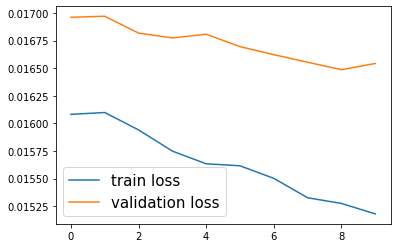

In [40]:
plt.plot(train_loss[-10:], label='train loss')
plt.plot(val_loss[-10:], label='validation loss')
plt.legend(fontsize=15)
plt.show()

In [41]:
with torch.no_grad():
    probs = model(torch.from_numpy(test_features.set_index('sig_id').to_numpy()).type(torch.FloatTensor).cuda()).cpu().numpy()
    pred_2 = pd.concat([test_features[['sig_id']], pd.DataFrame(probs, columns = train_targets_scored.columns.drop('sig_id'))], axis=1)

In [42]:
model =  MY_3(X_train.shape[1], y_train.shape[1], 8)
criterion = nn.BCELoss()
DEVICE = 'cuda'
model.cuda()
criterion.cuda()
opt = optim.Adam(params=model.parameters(), lr=1e-4)

In [43]:
EPOCHS = 500
# 500
train_loss = []
val_loss = []
for epoch in range(1, EPOCHS + 1):
    st = time.perf_counter()
    model.to(DEVICE)
    current_loss = 0
    model.train()
    for batch in train_iterator:
        opt.zero_grad()
        x, y = batch[:-1][0].cuda(), batch[-1].type(torch.FloatTensor).cuda()
        y_pred = model(x).type(torch.FloatTensor).cuda()
#         print(y)
#         print(y_pred)
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        current_loss += loss.item()/TRAIN_BATCHES_LEN
    train_loss.append(current_loss)
    
    model.eval()
    with torch.no_grad():
        current_loss = 0
        for batch in val_iterator:
            x, y = batch[:-1][0].cuda(), batch[-1].type(torch.FloatTensor).cuda()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            current_loss += loss.item()/VAL_BATCHES_LEN
        val_loss.append(current_loss)
    
#     torch.save(model.cpu().state_dict(), 'epoch{}'.format(epoch))
    
    print('Epoch: {}'.format(epoch), 'train loss: {:.5f}'.format(train_loss[-1]), 
         'val loss: {:.5f}'.format(val_loss[-1]), 'Time: {}'.format(time.perf_counter() - st))

Epoch: 1 train loss: 0.68716 val loss: 0.62128 Time: 1.8788494609999589
Epoch: 2 train loss: 0.45380 val loss: 0.31631 Time: 1.9465727670000206
Epoch: 3 train loss: 0.22359 val loss: 0.16171 Time: 1.8740860009999665
Epoch: 4 train loss: 0.13170 val loss: 0.10279 Time: 1.8845866300000012
Epoch: 5 train loss: 0.09188 val loss: 0.08104 Time: 2.0876927749999936
Epoch: 6 train loss: 0.07014 val loss: 0.06527 Time: 1.9011194590000287
Epoch: 7 train loss: 0.05673 val loss: 0.05205 Time: 1.9295705339999927
Epoch: 8 train loss: 0.04784 val loss: 0.04631 Time: 2.2219163030000004
Epoch: 9 train loss: 0.04165 val loss: 0.04051 Time: 2.075020664999954
Epoch: 10 train loss: 0.03709 val loss: 0.03582 Time: 2.1266134760000455
Epoch: 11 train loss: 0.03365 val loss: 0.03308 Time: 2.026194629000031
Epoch: 12 train loss: 0.03103 val loss: 0.03043 Time: 1.925712586999964
Epoch: 13 train loss: 0.02899 val loss: 0.02886 Time: 1.903590066999982
Epoch: 14 train loss: 0.02751 val loss: 0.02763 Time: 1.87524449

In [44]:
with torch.no_grad():
    probs = model(torch.from_numpy(test_features.set_index('sig_id').to_numpy()).type(torch.FloatTensor).cuda()).cpu().numpy()
    pred_3 = pd.concat([test_features[['sig_id']], pd.DataFrame(probs, columns = train_targets_scored.columns.drop('sig_id'))], axis=1)

In [45]:
submit = (pred_3.set_index('sig_id') + pred_2.set_index('sig_id') + pred_1.set_index('sig_id')) / 3

In [46]:
submit.reset_index().to_csv('submission.csv', index=None)